In [ ]:
# general use libraries
import math
from collections import Counter
# general machine learning libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# libraries to pre-process
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from itertools import product
# libraries to create the n-grams 
import nltk
from nltk.util import ngrams
# generate hashes
import mmh3

In [ ]:
df_10 = pd.read_csv("dataset_lab3/dataset_10/capture20110818.binetflow")
# drop the background flows so as to have only infected flows.
df_10.drop(df_10.loc[df_10.Label.str.contains("Background")].index.values, inplace=True)
df_10.reset_index(inplace=True)

In [ ]:
df_10.head()

,index,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,532,2011/08/18 10:19:15.693956,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,0.0,0.0,3049,978731,245317,flow=From-Normal-V51-Grill
1,822,2011/08/18 10:19:18.143576,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
2,842,2011/08/18 10:19:18.303590,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
3,1021,2011/08/18 10:19:19.838272,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek
4,1022,2011/08/18 10:19:19.839123,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek


In [22]:
# PRE-PROCESSING OF THE DATA SO AS TO HAVE THE DISCRETISED FEATURE.
# encode the 4 different values in 0,1,2,3
le = LabelEncoder()
Protocols = le.fit_transform(df_10['Proto']).reshape(-1, 1)
# discretise the totalpackets
est = KBinsDiscretizer(n_bins= 3, encode='ordinal', strategy='quantile')
TotPkts = est.fit_transform(df_10['TotPkts'].to_numpy().reshape(-1, 1))

# get the unique values so as to create the pairs that might be in the two features.
values_prot = np.unique(Protocols)
values_bytes = np.unique(TotPkts)

# The first number indicates which Protocol it is, and the second whether is small/medium/big size of packets.
c = list(product(values_prot, values_bytes))
Labels = { x : index for index, x in enumerate(c)}

# insert the two columns in a np array so we have a rows, 2 shape numpy array.
Combined_features = np.concatenate((Protocols, TotPkts), axis = 1)
# initialize an empty array to fill it with the new discrete values
Discretized_feature = np.zeros((Combined_features.shape[0], 1))
for index, row in enumerate(Combined_features):
    Discretized_feature[index] = Labels.get(tuple(row))

final_feature = pd.Series(Discretized_feature.reshape(-1,))



/home/marios/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [23]:
"""
Space saving algorithm

Input : data will be the stream of data we want to process, k is the number of counters.
"""
def space_Saving(data, k):
    # initialize an empty dictionary that will be used as both the set and the counters.
    k_counters = {}
    # go over each data point in the stream.
    for data_point in data:
        # if the data point is already in the set, increment by 1.
        if data_point in set(k_counters.keys()):
            k_counters[data_point] = k_counters[data_point] + 1
        # if the point isn't in the set and the set isn't full, add the data point and set the counter to 1.
        elif len(k_counters) < k:
            k_counters[data_point] = 1
        else:
            # it returns the minimum data point (trigram) that occurs in the data set. That will be the key in the dict.
            j = min(k_counters, key=k_counters.get) 
            # increase the counter and then replace the key with the new one.
            k_counters[j] = k_counters[j] + 1
            # update the key so as to be the new point.
            k_counters[data_point] = k_counters.pop(j)
    
    return k_counters



In [24]:
# create the 3-grams of discretised symbol.
n = 3
trigrams = list(ngrams(final_feature, n))
# also create a Series with the trigrams.
trigrams_Series = pd.Series(trigrams)

### Distribution of 3-grams using Space saving algorithm. 

In [25]:
# APPROXIMATIONS
# TODO : for second question use a rangoe of number of counters bla bla, as long as we increase counters, the approximation erros are decreased.
top_k = space_Saving(trigrams, 10)
top_k = dict(sorted(top_k.items(), key=lambda item: item[1], reverse=True))

In [26]:
"""
Function to plot histogram for 3-grams.
input : series is the density distribution, threshold is which bins to plot based on the density they have. If the element in series has > threshold is plotted, otherwise is added to other.
return : plots the histogram.
"""
def plot_histogram(series, title, threshold = 0.02):
    mask = series > threshold
    # for 3-grams that doesn't have a density of 1.5% we sum them and 
    # plot them as 'other' since it will be the tails.
    tail_prob = series.loc[~mask].sum()
    series = series.loc[mask]
    series['other'] = tail_prob
    series = series.round(4)
    ax = series.plot(kind='bar')
    plt.xticks(rotation=30)
    plt.xlabel('3-gram')
    plt.ylabel('Density')
    plt.title(title)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

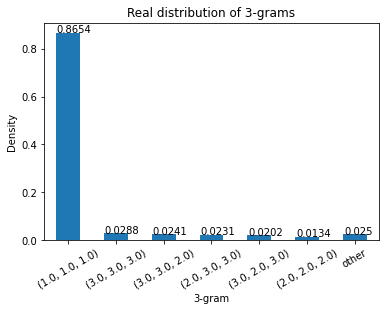

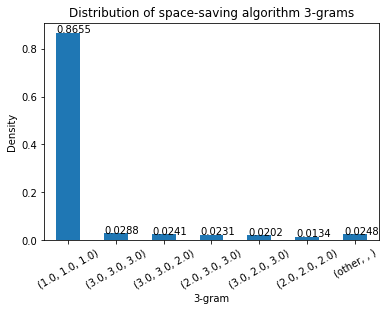

In [27]:
# plot the ground truth distribution
plot_histogram(trigrams_Series.value_counts(normalize=True), "Real distribution of 3-grams", threshold=0.01)
# plot after using space - saving algorithm
predictions = pd.Series(top_k)
# normalize the data based on all trigrams that are botnet + normal.
predictions = predictions / len(trigrams) 

plot_histogram(predictions, "Distribution of space-saving algorithm 3-grams", threshold=0.01)

According to theory SPACE SAVING have 3 properties : <br>
1) Smallest counter value min is at most m/k (m here is equal to len(trigrams) = 122197 and k is equal to counters) <br>
2) True counts of uncounted items is between 0 and min. <br>
2b) In addition All counts are overstimates so count of any item is off by at most m/k <br>
3) Any item x whose true count is > m/k is stored.

We can calculate between ground truth and predictions how off is a count of a trigram. That should align with 2b and not be over m/k.  



In [75]:
def approx_error(k):
    top_k = space_Saving(trigrams, k)
    top_k = dict(sorted(top_k.items(), key=lambda item: item[1], reverse=True))
    predictions = pd.Series(top_k)
    # take the absolute value of the difference.
    print("Frequencies when approximated")
    print("-" * 50)
    print(predictions[:10])
    print("-" * 50)
    print("Absolute differences between approximated frequencies and ground truth (absolute value)")
    print("-" * 50)
    print(np.abs((trigrams_Series.value_counts()[predictions.index]) - predictions)[:10])

In [76]:
approx_error(10)

Frequencies when approximated
--------------------------------------------------
1.0  1.0  1.0    105762
3.0  3.0  3.0      3525
          2.0      2949
2.0  3.0  3.0      2823
3.0  2.0  3.0      2470
2.0  2.0  2.0      1632
1.0  3.0  1.0       759
3.0  1.0  1.0       759
1.0  1.0  3.0       759
     3.0  3.0       759
dtype: int64
--------------------------------------------------
Absolute differences between approximated frequencies and ground truth (absolute value)
--------------------------------------------------
1.0  1.0  1.0     13
3.0  3.0  3.0      0
          2.0      0
2.0  3.0  3.0      0
3.0  2.0  3.0      0
2.0  2.0  2.0      0
1.0  3.0  1.0    557
3.0  1.0  1.0    521
1.0  1.0  3.0    443
     3.0  3.0    519
dtype: int64


In [77]:
approx_error(20)

Frequencies when approximated
--------------------------------------------------
1.0  1.0  1.0    105749
3.0  3.0  3.0      3525
          2.0      2949
2.0  3.0  3.0      2823
3.0  2.0  3.0      2470
2.0  2.0  2.0      1632
3.0  2.0  2.0       537
2.0  2.0  3.0       526
1.0  1.0  3.0       317
     3.0  3.0       243
dtype: int64
--------------------------------------------------
Absolute differences between approximated frequencies and ground truth (absolute value)
--------------------------------------------------
1.0  1.0  1.0    0
3.0  3.0  3.0    0
          2.0    0
2.0  3.0  3.0    0
3.0  2.0  3.0    0
2.0  2.0  2.0    0
3.0  2.0  2.0    0
2.0  2.0  3.0    0
1.0  1.0  3.0    1
     3.0  3.0    3
dtype: int64


The errors in approximated frequencies that we detect, are due to the fact that all counts are overstimates and using the theory, we know that will be at most m/k. Of course, increasing the counters will reduce the overstimates we make (since we won't have many swaps between the unique ngrams in the counters), and thus, get more reliable and close to ground truth counts. To get the 10 most frequent 3-grams as it is mentioned in the assignement we need at least 10 counters.

# Count-min sketch

In [31]:
"""
height : rows means how many hash functions we apply to each element, width (columns) : how many bins are for each hash function.
"""
class CountMinSketch:
    
    def __init__(self, height, width):
        # initialize the count-min sketch.
        self.count_sketch = np.zeros((height, width))
        # self.height is the number of hash functions applied to each element.
        self.height = height
        # self.width is the number of bins that corresponds to each hash function.
        self.width = width

    def calcHash(self, element, seed):
    # Calculation of the trigrams hash. We convert the tuple to np array so as to have different     # hash with 6,9,9 and 9,6,9. 
        res = np.asarray(element)
        result = mmh3.hash(res, seed) % self.width
        return result 

    def addToCM(self, element):
    # for each row in the Count-min skecth add the corresponding counts.
        for seed in range((self.height)):
            result = self.calcHash(element, seed)
            self.count_sketch[seed][result] += 1 

    def calulate_sketch(self, data):
        # iterate over the data set to add to Count-min sketch.
        for element in data:
            self.addToCM(element)
        
    def find_frequency(self, element):
        # for each row in the Count-min skecth find the corresponding 
        # hash value and find the minimum count.
        minimum = float('inf')
        for seed in range((self.height)):
            result = self.calcHash(element, seed)
            # the count hash that corresponds to the correct c-m entry.
            curr = self.count_sketch[seed][result]
            if minimum > curr: minimum = curr
        
        return int(minimum)

In [32]:
# assign hash functions = 10, bins = 10
c_m = CountMinSketch(10, 10)
# compute the compute min sketch using all data.
c_m.calulate_sketch(trigrams_Series)

In [33]:
# for all unique trigrams calculate the frequency using Count min sketch.
predictions_CM = {i : 0 for i in trigrams_Series.value_counts().index}
for trigram in trigrams_Series.value_counts().index:
    predictions_CM[trigram] = c_m.find_frequency(trigram)

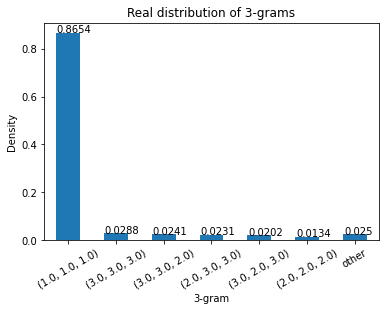

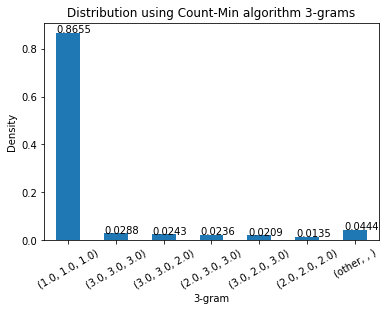

In [34]:
# plot the real distribution.
plot_histogram(trigrams_Series.value_counts(normalize=True), "Real distribution of 3-grams", threshold=0.01)

predicts_CM = pd.Series(predictions_CM)
# normalize the data based on all trigrams that are botnet + normal.
predicts_CM = predicts_CM / len(trigrams) 

plot_histogram(predicts_CM, "Distribution using Count-Min algorithm 3-grams", threshold=0.01)

In [72]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def approx_error(hash_nums, bins):
    # assign hash functions = 10, bins = 10
    c_m = CountMinSketch(hash_nums, bins)
    # compute the compute min sketch using all data.
    c_m.calulate_sketch(trigrams_Series)
    # for all unique trigrams calculate the frequency using Count min sketch.
    predictions_CM = {i : 0 for i in trigrams_Series.value_counts().index}
    for trigram in trigrams_Series.value_counts().index:
        predictions_CM[trigram] = c_m.find_frequency(trigram)
    
    predictions_CM = dict(sorted(predictions_CM.items(), key=lambda item: item[1], reverse=True))
    # take the absolute value of the difference.
    print("Frequencies when approximated")
    print("-" * 50)
    top_10_preds = take(10, predictions_CM.items())
    top_10 = { x[0] : x[1] for x in top_10_preds}
    top_10 = pd.Series(top_10)
    print(top_10)
    print("-" * 50)
    print("Absolute differences between approximated frequencies and ground truth (absolute value)")
    print("-" * 50)

    print(np.abs((trigrams_Series.value_counts()[top_10.index]) - top_10)[:10])

In [73]:
approx_error(5, 5) 

Frequencies when approximated
--------------------------------------------------
1.0  1.0  1.0    106042
3.0  3.0  3.0      4564
2.0  3.0  3.0      3465
1.0  3.0  3.0      3465
3.0  3.0  2.0      3303
     2.0  3.0      2994
          1.0      2994
1.0  2.0  1.0      2994
2.0  2.0  2.0      2686
     3.0  1.0      2686
dtype: int64
--------------------------------------------------
Absolute differences between approximated frequencies and ground truth (absolute value)
--------------------------------------------------
1.0  1.0  1.0     293
3.0  3.0  3.0    1039
2.0  3.0  3.0     642
1.0  3.0  3.0    3225
3.0  3.0  2.0     354
     2.0  3.0     524
          1.0    2874
1.0  2.0  1.0    2934
2.0  2.0  2.0    1054
     3.0  1.0    2667
dtype: int64


In [74]:
approx_error(15, 15)

Frequencies when approximated
--------------------------------------------------
1.0  1.0  1.0    105749
3.0  3.0  3.0      3525
          2.0      2949
2.0  3.0  3.0      2823
3.0  2.0  3.0      2475
2.0  2.0  2.0      1649
3.0  2.0  2.0       538
2.0  2.0  3.0       526
1.0  1.0  3.0       316
     3.0  3.0       263
dtype: int64
--------------------------------------------------
Absolute differences between approximated frequencies and ground truth (absolute value)
--------------------------------------------------
1.0  1.0  1.0     0
3.0  3.0  3.0     0
          2.0     0
2.0  3.0  3.0     0
3.0  2.0  3.0     5
2.0  2.0  2.0    17
3.0  2.0  2.0     1
2.0  2.0  3.0     0
1.0  1.0  3.0     0
     3.0  3.0    23
dtype: int64


The errors in the approximated frequencies we observe are a bit off (the less hash functions and bins we use the more off the approximations are), because the counts are also overstimates as in space saving, but here is due to collisions among the hash functions. Using more hash functions and bins will reduce the collisions and ,thus, will lead to better results that are closer to ground truth counts.
